#### Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Directories + Hyperparameters

In [6]:
train_dir = '/kaggle/input/emotion-detection-fer/train'
test_dir = '/kaggle/input/emotion-detection-fer/test'
    
img_size = 48
batch_size = 64
seed = 15
epochs = 20
num_classes = 0

class_labels = []

for num_classes, label in enumerate(os.listdir(train_dir)):
    num_classes += 1
    class_labels.append(label)
    
print(class_labels)
print(f"Num of class: {num_classes}")



['fearful', 'disgusted', 'angry', 'neutral', 'sad', 'surprised', 'happy']
Num of class: 7


#### Data Visualization

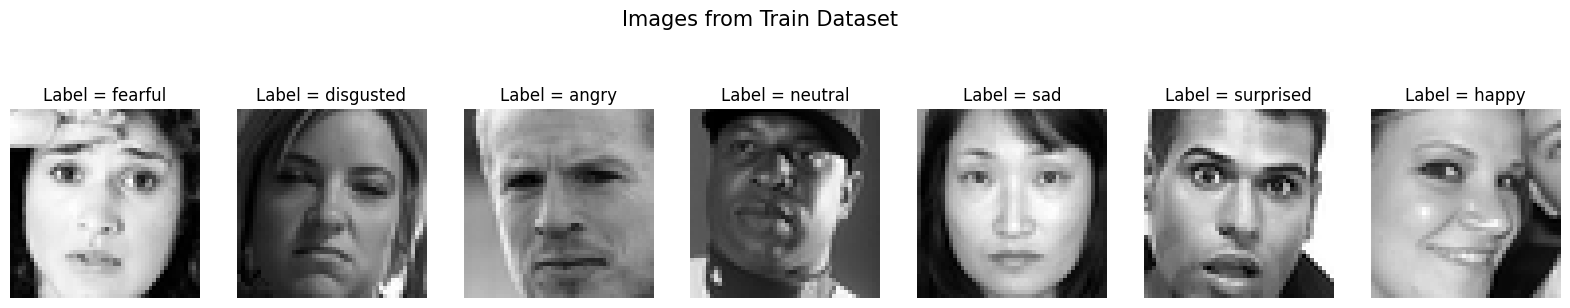

In [9]:
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
fig.suptitle('Images from Train Dataset', fontsize=15)

axes = axes.flatten()

for i, label in enumerate(os.listdir(train_dir)):
    if i == len(axes):
        break
    
    label_path = os.path.join(train_dir, label)
    
    if os.path.isdir(label_path):
        img_file = [f for f in os.listdir(label_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if img_file:
            random_img = random.choice(img_file)
            
            img_path = os.path.join(label_path, random_img)
            
            img = mpimg.imread(img_path)
            
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Label = {label}")
            axes[i].axis('off')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


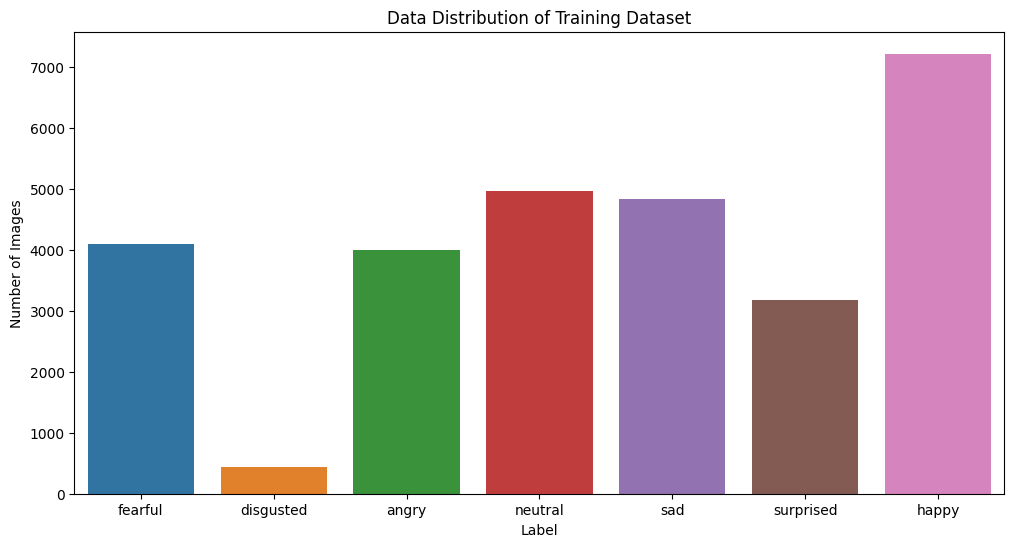

In [10]:
label_cnt = {}

for label in class_labels:
    label_path = os.path.join(train_dir, label)
    num_img = len([f for f in os.listdir(label_path)])
    label_cnt[label] = num_img

plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_cnt.keys()), y=list(label_cnt.values()))
plt.title('Data Distribution of Training Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.show()

#### Pre-processing

In [11]:
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image

In [18]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2
                                 )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (img_size,img_size),
                                                  color_mode = "grayscale",
                                                  class_mode = "categorical"
                                                  )

validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


#### Model

In [13]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Flatten
from tensorflow.keras import Sequential
from keras import regularizers

In [14]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)),
    Conv2D(64,(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(128,(5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Dense(512,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

#### Training

In [19]:
history = model.fit(x=train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
359/359 [==============================] - 30s 84ms/step - loss: 1.9536 - accuracy: 0.5203 - val_loss: 1.9046 - val_accuracy: 0.5328
Epoch 2/30
359/359 [==============================] - 31s 86ms/step - loss: 1.9496 - accuracy: 0.5217 - val_loss: 2.0344 - val_accuracy: 0.5405
Epoch 3/30
359/359 [==============================] - 30s 84ms/step - loss: 1.9715 - accuracy: 0.5281 - val_loss: 1.8826 - val_accuracy: 0.5628
Epoch 4/30
359/359 [==============================] - 34s 94ms/step - loss: 1.8966 - accuracy: 0.5295 - val_loss: 2.1839 - val_accuracy: 0.4986
Epoch 5/30
359/359 [==============================] - 37s 104ms/step - loss: 1.8998 - accuracy: 0.5361 - val_loss: 1.7241 - val_accuracy: 0.5587
Epoch 6/30
359/359 [==============================] - 36s 99ms/step - loss: 1.8434 - accuracy: 0.5375 - val_loss: 1.7747 - val_accuracy: 0.5426
Epoch 7/30
359/359 [==============================] - 33s 91ms/step - loss: 1.8591 - accuracy: 0.5330 - val_loss: 1.7699 - val_accuracy

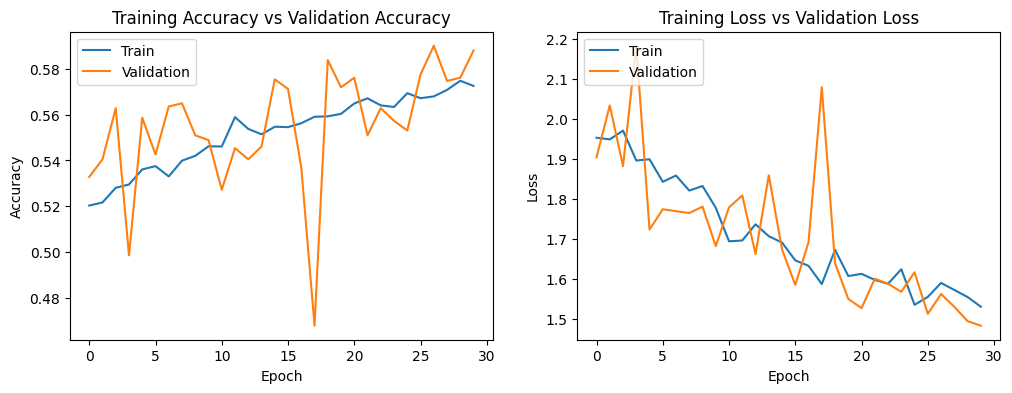

In [20]:
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### Testing

In [22]:
label_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}

1/1 [==============================] - 0s 18ms/step
Sad


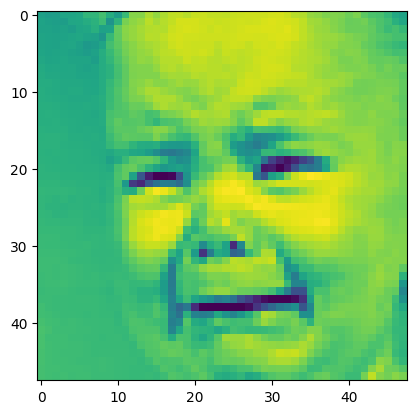

In [28]:
img = image.load_img("/kaggle/input/emotion-detection-fer/test/sad/im1017.png",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)

img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])

img_index = result.index(max(result))
print(label_dict[img_index])

In [24]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)
print("train accuracy = {:.2f} , test accuracy = {:.2f}".format(train_acc*100, test_acc*100))

225/225 [==============================] - 29s 130ms/step - loss: 1.4668 - accuracy: 0.5901
train accuracy = 60.10 , test accuracy = 59.01


#### Saving Model

In [29]:
model.save('model_1.h5')
model.save_weights('model_weights1.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
